In [ ]:
# default_exp funcs.merfish_comparison

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict
import torch.nn as nn
import torch.nn.functional as F
import torch.tensor as T
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

sys.path.append('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/FQ/istdeco/')

from istdeco import ISTDeco
from utils import random_codebook, random_image_stack
from codebook import Codebook
from starfish.image import Filter

sys.path.append('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/FQ/bardensr/')
import bardensr

import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

2021-09-27 04:42:13.571089: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_13/start_mic:5000xpsf_noise:0.4/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_9a/old_new_format/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_11/seed:1xint_fac:0.1/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sim_1/old_loss:Truexmin_int_sig:1.0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sim_1/old_loss:False/train.yaml')
# csv_name = 'test'
# cfg.foci.n_foci_avg = 0

In [ ]:
# cfg.exp_type.pred_z=False
# cfg.PSF.psf_extent_zyx=[1,21,21]
# cfg.run_name = 'test'

In [ ]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sim_2/test1/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sim_1b/old_loss:Falsexpsf_noise:0.0xint_fac:0.0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sim_2c/old_loss:0xint_option:3xmin_int_sig:1.0/train.yaml')

In [ ]:
crop_sz = 128
cfg.foci.n_foci_avg = 0
cfg.training.bs = 5
cfg.PSF.n_cols = 1
cfg.random_crop.crop_sz = crop_sz
cfg.data_path.image_shape = [16,1,crop_sz,crop_sz]

model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 128, 128)
1 volumes


In [ ]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
import h5py
from decode_fish.funcs.routines import *

with torch.no_grad():

    x, local_rate, background = next(iter(decode_dl))
    sim_vars = PointProcessUniform(local_rate*0 + 0.1, model.int_dist.int_conc, model.int_dist.int_rate, 
                                   model.int_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(code_inds), int_option=3).sample(from_code_book=True, phasing=cfg.exp_type.phasing)
    xsim = micro(*sim_vars, add_noise=False)
    xsimn = micro.noise(xsim, background).sample()

    gt_vars = sim_vars[:-1]
    gt_df = px_to_nm(sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.]))

# with h5py.File('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data1/dens_0.1_int_1.0.h5', 'r') as f:

#     xsimn = f['frames'][()]
#     gt_df = get_df_from_hdf5(f['locations']) 
        
# with h5py.File('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data1/sim_2/dens_0.1_int_1.0.h5', 'r') as f:

#     dec_df = get_df_from_hdf5(f['old_loss:False']['locations_int'])

In [ ]:
gt_df = get_code_from_ints(gt_df, code_ref, targets, int_str='', p_str='')
# gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

In [ ]:
# gt_df = gt_df.loc[:,['frame_idx', 'code_inds', 'x', 'y', 'z']+[f'int_{i}' for i in range(16)]]
# np.save('../data/chen_bardensr/sim_data.npy',cpu(xsimn))
# gt_df.to_csv('../data/chen_bardensr/gt_df.csv', index=False)
# np.save('../data/chen_bardensr/codebook.npy',cpu(code_ref))

In [ ]:
with torch.no_grad():
    
    model.eval().cuda()
    res_dict = model(T(xsimn).cuda())
    res_dict = model.tensor_to_dict(res_dict)
    pred_df = post_proc.get_df(res_dict, softmax=False)
    pred_df = get_code_from_ints(pred_df, code_ref, targets, func=vcorrcoef, int_str='', p_str='')
    pred_df = exclude_borders(pred_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


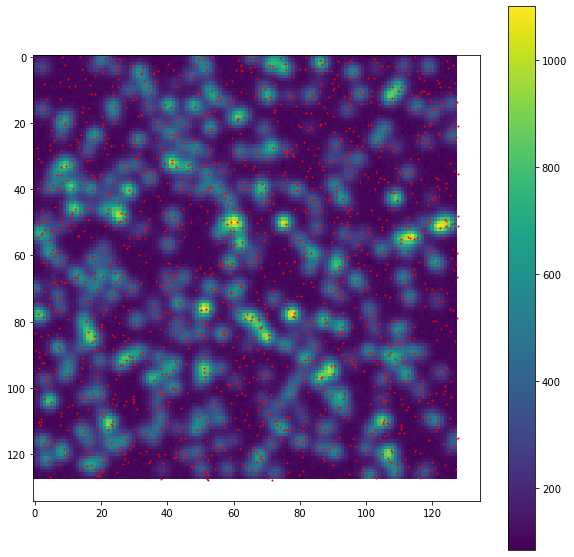

In [ ]:
plt.figure(figsize=(10,10))
sub = gt_df[gt_df['frame_idx'] == 0]
# sub = sub[sub['int_0'] > 0]
plt.imshow(cpu(xsimn)[0,0,0])
plt.colorbar()
plt.scatter(sub['x']/100, sub['y']/100, color='red', s=1)

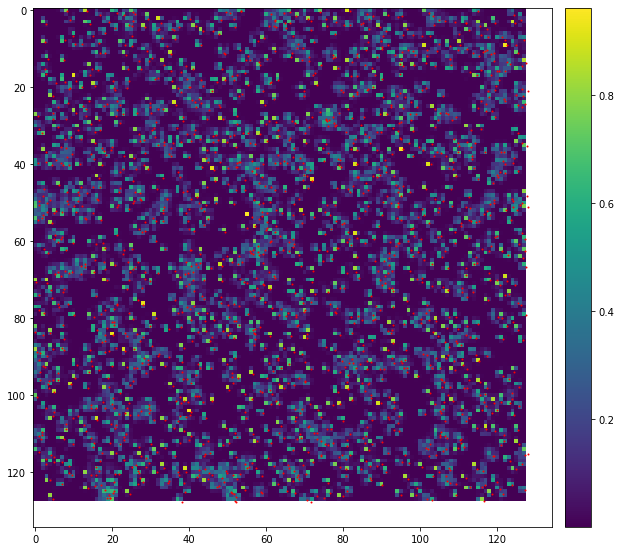

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(cpu(torch.sigmoid(res_dict['logits']))[0,0,0])
add_colorbar(im)
plt.scatter(sub['x']/100, sub['y']/100, color='red', s=1)

In [ ]:
res_dict.keys()

dict_keys(['logits', 'xyzi_mu', 'xyzi_sigma', 'background', 'int_logits', 'Probs_si', 'Samples_si'])

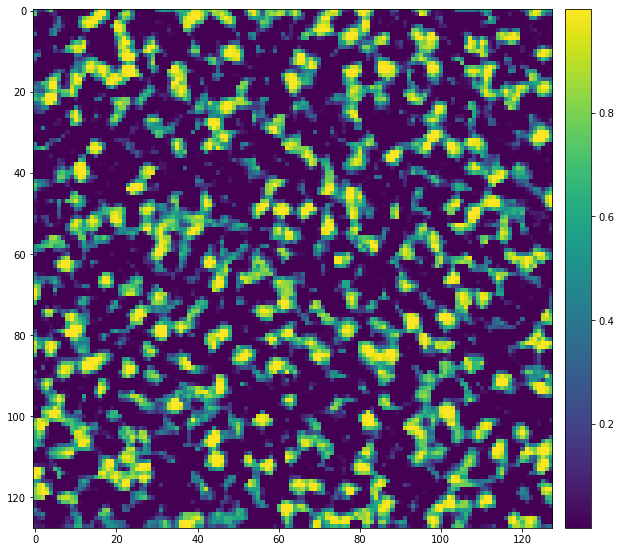

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(cpu(torch.sigmoid(res_dict['int_logits']))[0,2,0])
add_colorbar(im)

In [ ]:
# sub_df = percentile_filter(pred_df, 97, 'code_err')
perf, matches, _  = matching(gt_df, pred_df, match_genes=False, tolerance=300)
print(f'-------', sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches))
perf, matches, _  = matching(gt_df, pred_df, match_genes=True, tolerance=300)

Recall: 0.843
Precision: 0.993
Jaccard: 83.781
RMSE_vol: 9.823
Eff_3d: 83.053
FN: 134.0 FP: 5.0
Num. matches: 718.000
Shift: 0.50,0.02,0.00
------- 0.9958217270194986
Recall: 0.840
Precision: 0.990
Jaccard: 83.353
RMSE_vol: 9.726
Eff_3d: 82.657
FN: 136.0 FP: 7.0
Num. matches: 716.000
Shift: 0.59,-0.12,0.00


In [ ]:
# export
def get_istdeco_df(sim_data, codebook, psf_sig=(1.7, 1.7), n_iter=100, bg=100.):
    
    istd_results = pd.DataFrame()
    
    n_rounds = codebook.shape[1]
    n_cols = codebook.shape[2]
    
    for i in range(len(sim_data)):

        image_data = np.array(sim_data)[i,:,0]
        image_data = image_data.reshape([n_rounds,n_cols,image_data.shape[-2],image_data.shape[-1]], order='F')
        
        init_th = np.percentile(image_data,50)

        istdeco_model = ISTDeco(image_data, codebook, psf_sig, b=bg)
        X, Q, loss = istdeco_model.run(niter=n_iter)

        # Get codes
        code_id, y, x = np.where(np.logical_and(X>init_th,Q>0.1))

        intensity = X[code_id, y, x]
        quality = Q[code_id, y, x]

        # Store in dataframe
        df = pd.DataFrame(data={
                'frame_idx': i,
                'x': x.astype('float')+0.5, 
                'y': y.astype('float')+0.5,
                'z': 0.5,
                'intensity': intensity, 
                'quality': quality,
                'code_inds': code_id
        })

        istd_results = istd_results.append(df)

    istd_results = px_to_nm(istd_results)

    return istd_results

In [ ]:
istd_df = get_istdeco_df(cpu(xsimn), code_ref.reshape([140,8,2], order='F'), psf_sig=(1.7, 1.7), n_iter=400)
# istd_df = exclude_borders(istd_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

In [ ]:
sub_df = istd_df[istd_df['quality'] > 0.25]
sub_df = sub_df[sub_df['intensity'] > 2400]

In [ ]:
perf, matches, _  = matching(gt_df, sub_df, match_genes=False)
print(f'-------', sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches))
perf, matches, _  = matching(gt_df, sub_df, match_genes=True)

Recall: 0.886
Precision: 0.984
Jaccard: 87.293
RMSE_vol: 65.712
Eff_3d: 64.773
FN: 945.0 FP: 122.0
Num. matches: 7330.000
Shift: 0.14,0.18,0.00
------- 0.8885402455661664
Recall: 0.844
Precision: 0.937
Jaccard: 79.902
RMSE_vol: 48.365
Eff_3d: 68.556
FN: 1290.0 FP: 467.0
Num. matches: 6985.000
Shift: 0.49,0.16,0.00


In [ ]:
istd_df = get_istdeco_df(cpu(xsimn), code_ref.reshape([140,8,2], order='F'), psf_sig=(1.7, 1.7), n_iter=400)
# istd_df = exclude_borders(istd_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

q_max = 0.3*istd_df['quality'].max()
i_max = 0.3*istd_df['intensity'].max()
i_min = istd_df['intensity'].min()

def objective(trial):
    
    n_iter = 400 # trial.suggest_uniform('n_iter', 50, 500)
    psf_s = 1.7 # trial.suggest_uniform('psf_s', 1.5, 1.7)
    
#     istd_df = get_istdeco_df(xsimn, code_ref.reshape([140,8,2], order='F'), psf_sig=(psf_s, psf_s), n_iter=int(n_iter))
#     istd_df = exclude_borders(istd_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])
    
    qual_th = trial.suggest_uniform('qual_th', 0.1, q_max)
    int_th = trial.suggest_uniform('int_th', i_min, i_max)
    
    sub_df = istd_df[(istd_df['intensity'] > int_th) & (istd_df['quality'] > qual_th)]
    perf, matches, _  = matching(gt_df, sub_df, match_genes=True, print_res=False) 
    
    return -perf['jaccard']

study = optuna.create_study()
study.optimize(objective, n_trials=200)

print(study.best_params)
print('Jaccard ', -study.best_value)

[I 2021-09-27 04:47:09,894] A new study created in memory with name: no-name-13dbc776-1ab9-4e22-853f-0c2034084d34
[I 2021-09-27 04:47:09,970] Trial 0 finished with value: -0.04773561694649652 and parameters: {'qual_th': 0.23206452972466116, 'int_th': 17707.247354206604}. Best is trial 0 with value: -0.04773561694649652.
[I 2021-09-27 04:47:10,086] Trial 1 finished with value: -0.10807833272758059 and parameters: {'qual_th': 0.6542643481946226, 'int_th': 13731.30423736906}. Best is trial 1 with value: -0.10807833272758059.
[I 2021-09-27 04:47:11,116] Trial 2 finished with value: -0.5060886384294048 and parameters: {'qual_th': 0.6119120894678014, 'int_th': 2428.874788194227}. Best is trial 2 with value: -0.5060886384294048.
[I 2021-09-27 04:47:11,169] Trial 3 finished with value: -0.029865360346013208 and parameters: {'qual_th': 0.8193523826773111, 'int_th': 19709.00048257112}. Best is trial 2 with value: -0.5060886384294048.
[I 2021-09-27 04:47:11,250] Trial 4 finished with value: -0.07

KeyboardInterrupt: 

In [ ]:
sub_df = istd_df[(istd_df['intensity'] > study.best_params['int_th']) & (istd_df['quality'] > study.best_params['qual_th'])]
perf, matches, _  = matching(gt_df, sub_df, match_genes=False)
print(f'-------', sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches))
perf, matches, _  = matching(gt_df, sub_df, match_genes=True)

Recall: 0.890
Precision: 0.982
Jaccard: 87.553
RMSE_vol: 65.295
Eff_3d: 65.060
FN: 889.0 FP: 134.0
Num. matches: 7196.000
Shift: -0.75,-0.26,0.00
------- 0.8889660922734852
Recall: 0.850
Precision: 0.937
Jaccard: 80.419
RMSE_vol: 50.034
Eff_3d: 68.231
FN: 1214.0 FP: 459.0
Num. matches: 6871.000
Shift: -0.44,0.43,0.00


In [ ]:
# export
def get_bardensr_tensor(sim_data, codebook, bg=100., n_iter=400, l1_pen=0., psf_r=0):
    
    bard_results = pd.DataFrame()
    evd_tensors = []
    codeflat = codebook.T
    
    for i in range(len(sim_data)):
    
        image_data = sim_data[i]
        Xnorm = image_data - bg
#         Xnorm /= Xnorm.max()
        
#         Xnorm = bardensr.preprocessing.minmax(image_data - bg)

#         Xnorm = bardensr.preprocessing.minmax(image_data)
#         Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
        Xnorm = bardensr.preprocessing.minmax(Xnorm)

        evidence_tensor_iterative,extra_learned_params=\
            bardensr.spot_calling.estimate_density_iterative(Xnorm.astype('float64'),codeflat,l1_penalty=l1_pen,use_tqdm_notebook=True,iterations=n_iter, estimate_codebook_gain=True, psf_radius=(psf_r, psf_r, psf_r))

#         evidence_tensor_iterative= bardensr.spot_calling.estimate_density_singleshot(Xnorm.astype('float64'), codeflat, noisefloor=0.05)
    
        evd_tensors.append(evidence_tensor_iterative)
        
    return evd_tensors

def get_bardensr_df(evd_tensors, th, ps=1.0):
    
    bard_results = pd.DataFrame()

    for i in range(len(evd_tensors)):    
    #     thresh_iterative=evd_tensors[i].max()*.1
        result_iterative=bardensr.spot_calling.find_peaks(evd_tensors[i],th, poolsize=(ps,ps,ps))

        code_inds = np.array(result_iterative.j.values, dtype=np.int16)
        df = pd.DataFrame(data={
                    'frame_idx': i,
                    'x': result_iterative.m2.values + 0.5, 
                    'y': result_iterative.m1.values + 0.5,
                    'z': 0.5,
                    'intensity': result_iterative.int.values,
                    'code_inds': code_inds
            })

        bard_results = bard_results.append(df)

    bard_results = px_to_nm(bard_results)
    return bard_results

In [ ]:
evd_tensors = get_bardensr_tensor(cpu(xsimn), code_ref, n_iter=100, l1_pen=.01, bg=100., psf_r=0)

2021-09-25 11:24:06.459223: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-25 11:24:06.460009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-25 11:24:06.461228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2021-09-25 11:24:06.461275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-25 11:24:06.461340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-25 11:24:06.461381: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-09-25 11

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
bard_df = get_bardensr_df(evd_tensors, th=.25, ps=1.05)
# bard_df = exclude_borders(bard_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

2021-09-25 11:24:10.373225: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [ ]:
len(bard_df)

8159

In [ ]:
perf, matches, _  = matching(gt_df, bard_df, match_genes=False)
print(f'-------', sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches))
perf, matches, _  = matching(gt_df, bard_df, match_genes=True)

Recall: 0.858
Precision: 0.850
Jaccard: 74.517
RMSE_vol: 143.815
Eff_3d: 23.711
FN: 1149.0 FP: 1223.0
Num. matches: 6936.000
Shift: -1.75,2.97,0.00
------- 0.5641580161476355
Recall: 0.623
Precision: 0.618
Jaccard: 44.984
RMSE_vol: 81.173
Eff_3d: 31.633
FN: 3045.0 FP: 3119.0
Num. matches: 5040.000
Shift: 0.37,1.18,0.00


In [ ]:
# evd_tensors = get_bardensr_tensor(xsimn, code_ref, n_iter=int(300), l1_pen=0.01)

def objective(trial):
    
#     n_iter = 300
#     l1_pen = trial.suggest_uniform('l1_pen', 0., 0.1)
    th     = trial.suggest_uniform('th', 0.2, 0.6)
    ps     = trial.suggest_uniform('ps', 0.1, 1.5)
    
#     evd_tensors = get_bardensr_tensor(xsimn, code_ref, n_iter=int(n_iter), l1_pen=l1_pen)
#     print(evd_tensors[0].mean())
    bard_df = get_bardensr_df(evd_tensors, th, ps)
    bard_df = exclude_borders(bard_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])
    
    perf, matches, _  = matching(gt_df, bard_df, match_genes=True, print_res=False) 
    
    return -perf['jaccard']

study = optuna.create_study()
study.optimize(objective, n_trials=200)

print(study.best_params)
print('Jaccard ', -study.best_value)

In [ ]:
evd_tensors = get_bardensr_tensor(cpu(xsimn), code_ref, n_iter=100, l1_pen=.05, bg=100., psf_r=0)

In [ ]:
bard_df = get_bardensr_df(evd_tensors, th=study.best_params['th'], ps=study.best_params['ps'])
# bard_df = get_bardensr_df(evd_tensors, th=0.5, ps=1.05)
bard_df = exclude_borders(bard_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])
perf, matches, _  = matching(gt_df, bard_df, match_genes=False)
print(f'-------', sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches))
perf, matches, _  = matching(gt_df, bard_df, match_genes=True)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted index.ipynb.
